In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from itertools import product
from fbprophet import Prophet
from chinese_calendar import get_holidays, is_holiday, is_workday

import gc
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

Importing plotly failed. Interactive plots will not work.


## 载入数据

In [2]:
path = './data/'
balance_user = pd.read_csv(path + 'user_balance_table.csv').sort_values(['user_id', 'report_date']).reset_index(drop=True)
balance_user['report_date'] = pd.to_datetime(balance_user['report_date'].astype(str))
balance_user.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-03-20,20111,0,20111,20111,0,20111,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,1,2014-03-21,20111,20111,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2,1,2014-03-22,20113,20111,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-03-23,20115,20113,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-03-24,20117,20115,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [153]:
# 待预测数据 2014年9月每一天的申购总额和赎回总额
test = pd.DataFrame()
test['report_date'] = pd.date_range('20140901', '20140930')
# test['report_date'] = test['report_date'].dt.strftime('%Y%m%d')
test['purchase'] = np.nan
test['redeem'] = np.nan
test.head(3)

,report_date,purchase,redeem
0,2014-09-01,NaN,NaN
1,2014-09-02,NaN,NaN
2,2014-09-03,NaN,NaN


In [9]:
train = balance_user.groupby('report_date')['total_purchase_amt', 'total_redeem_amt'].sum()
train.columns = ['purchase', 'redeem']
# train['report_date'] = train.index
train.reset_index(inplace=True)
train.head()

,report_date,purchase,redeem
0,2013-07-01,32488348,5525022
1,2013-07-02,29037390,2554548
2,2013-07-03,27270770,5953867
3,2013-07-04,18321185,6410729
4,2013-07-05,11648749,2763587


In [10]:
data = pd.concat([train, test], ignore_index=True)
data

,report_date,purchase,redeem
0,2013-07-01,32488348.0,5525022.0
1,2013-07-02,29037390.0,2554548.0
2,2013-07-03,27270770.0,5953867.0
3,2013-07-04,18321185.0,6410729.0
4,2013-07-05,11648749.0,2763587.0
...,...,...,...
452,2014-09-26,NaN,NaN
453,2014-09-27,NaN,NaN
454,2014-09-28,NaN,NaN
455,2014-09-29,NaN,NaN


In [4]:
pd.date_range('2013-7-1', '2014-8-31', freq='m')

DatetimeIndex(['2013-07-31', '2013-08-31', '2013-09-30', '2013-10-31',
               '2013-11-30', '2013-12-31', '2014-01-31', '2014-02-28',
               '2014-03-31', '2014-04-30', '2014-05-31', '2014-06-30',
               '2014-07-31', '2014-08-31'],
              dtype='datetime64[ns]', freq='M')

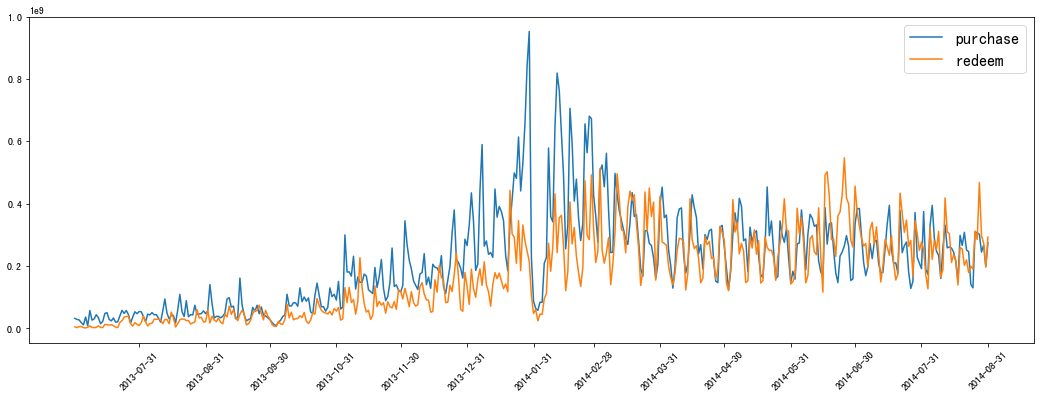

In [5]:
plt.figure(figsize=(18,6))
plt.plot(train['report_date'], train['purchase'], label='purchase')
plt.plot(train['report_date'], train['redeem'], label='redeem')
plt.xticks(pd.date_range('2013-7-1', '2014-8-31', freq='m'), map(lambda t: t.strftime('%Y-%m-%d'), pd.date_range('2013-7-1', '2014-8-31', freq='m')), rotation=45)
plt.legend(fontsize=16);

In [11]:
def time2multi(data, time_fea='report_date'):
#     holidays = get_holidays(data[time_fea].min(), data[time_fea].max(), include_weekends=False)
    data['weekday'] = data[time_fea].dt.weekday + 1  # 星期几
    data['month'] = data[time_fea].dt.month
    data['week'] = data[time_fea].dt.week
    data['day'] = data[time_fea].dt.day
    # 节假日和周末标签
    data['is_holiday'] = data[time_fea].apply(lambda x: int(is_holiday(x)))
#     data['is_holiday'][data[time_fea].isin(holidays)] = 1
#     data['is_weekend'] = data['weekday'].isin([6, 7]).astype(int)
    return data

In [26]:
train = time2multi(train)
train.head(3)

,report_date,purchase,redeem,weekday,month,week,day,is_holiday
0,2013-07-01,32488348,5525022,1,7,27,1,0
1,2013-07-02,29037390,2554548,2,7,27,2,0
2,2013-07-03,27270770,5953867,3,7,27,3,0


In [27]:
train = train[train['report_date'] >= '20140301']
train.head(3)

,report_date,purchase,redeem,weekday,month,week,day,is_holiday
243,2014-03-01,362865580,211279011,6,3,9,1,1
244,2014-03-02,276202230,246199417,7,3,9,2,1
245,2014-03-03,505305862,513017360,1,3,10,3,0


In [12]:
data = time2multi(data)
data = data[data['report_date'] >= '20140301']
data

,report_date,purchase,redeem,weekday,month,week,day,is_holiday
243,2014-03-01,362865580.0,211279011.0,6,3,9,1,1
244,2014-03-02,276202230.0,246199417.0,7,3,9,2,1
245,2014-03-03,505305862.0,513017360.0,1,3,10,3,0
246,2014-03-04,524146340.0,250562978.0,2,3,10,4,0
247,2014-03-05,454295491.0,209072753.0,3,3,10,5,0
...,...,...,...,...,...,...,...,...
452,2014-09-26,NaN,NaN,5,9,39,26,0
453,2014-09-27,NaN,NaN,6,9,39,27,1
454,2014-09-28,NaN,NaN,7,9,39,28,0
455,2014-09-29,NaN,NaN,1,9,40,29,0


## 思考
尽管从结果来看，分数130分很不错，但感觉还是存在点问题。由于使用的data数据包含了待预测的9月，因此除以`len(data['month'].unique())`时相当于多除了，但结果却是很好；如果改回去掉9月后的数据来算的话，结果只有不到100分，所以受这个参数影响比较大。

In [160]:
def get_period_factors_2(data, window=None):
    """
    window表示的是使用过去多少天的数据来计算base的值;
    未处理holiday
    """
    data = data.copy()
    feas = ['purchase', 'redeem']
    if window == None:
        # window = len(data.dropna())
        window = len(data)
    # weekday因子
    # 按weekday计算平均值
    # weekday_ft = data.dropna()[-window:].groupby('weekday')[feas].mean()
    weekday_ft = data[-window:].groupby('weekday')[feas].mean()
    wd_cols = [f + '_wd_ft' for f in feas]
    weekday_ft.columns = wd_cols
    # 基于历史数据计算base
    # base = data.dropna()[-window:][feas].mean().values
    base = data[-window:][feas].mean().values
    weekday_ft /= base
    data = data.merge(weekday_ft, how='left', on='weekday')
    # 日期因子
    # tmp = data.dropna()[-window:].groupby(['day', 'weekday'], as_index=False)['report_date'].count()
    tmp = data[-window:].groupby(['day', 'weekday'], as_index=False)['report_date'].count()
    tmp = tmp.merge(data.dropna().groupby('day')['month'].count(), on='day')
    tmp.columns = ['day', 'weekday', 'day_wd_count', 'month_count']
    tmp = tmp.merge(weekday_ft, on='weekday')
    # weekday因子对日期的影响
    tmp[wd_cols] = tmp[wd_cols] * tmp[['day_wd_count']].values / len(data['month'].unique())
#     tmp[wd_cols] = tmp[wd_cols] * tmp[['day_wd_count']].values / tmp[['month_count']].values
    day_ft = tmp.drop(['weekday', 'day_wd_count', 'month_count'], axis=1).groupby('day').sum()
    day_ft.columns = [f + '_day_ft' for f in feas]
    day_base = data.groupby(['day'])[feas].mean() / day_ft.values
    day_base.columns = [f + '_day_base' for f in feas]
    return day_base, weekday_ft
#     data = data.merge(day_ft, how='left', on='day')
#     data = data.merge(day_base, how='left', on='day')
#     return data

In [186]:
data.head(3)

,report_date,purchase,redeem,weekday,month,week,day,is_holiday
243,2014-03-01,362865580.0,211279011.0,6,3,9,1,1
244,2014-03-02,276202230.0,246199417.0,7,3,9,2,1
245,2014-03-03,505305862.0,513017360.0,1,3,10,3,0


In [230]:
def get_period_factors(data, window=None, holiday=True):
    """
    window表示的是使用过去多少天的数据来计算base的值;
    未处理holiday
    """
    data = data.copy()
    if holiday:
        rows_not_hol = data['weekday'].isin([6, 7]) & (data['is_holiday'] != 1)
        rows_hol = (data['weekday'].isin([1,2,3,4,5])) & (data['is_holiday'] == 1)
        data['weekday'][rows_not_hol] = 1
        data['weekday'][rows_hol] = data['weekday'][rows_hol].apply(lambda x: 7 if x>=3 else 6)
    feas = ['purchase', 'redeem']
    if window == None:
        # window = len(data.dropna())
        window = len(data)
    # weekday因子
    # 按weekday计算平均值
    # weekday_ft = data.dropna()[-window:].groupby('weekday')[feas].mean()
    weekday_ft = data[-window:].groupby('weekday')[feas].mean()
    wd_cols = [f + '_wd_ft' for f in feas]
    weekday_ft.columns = wd_cols
    # 基于历史数据计算base
    # base = data.dropna()[-window:][feas].mean().values
    base = data[-window:][feas].mean().values
    weekday_ft /= base
    data = data.merge(weekday_ft, how='left', on='weekday')
    # 日期因子
    # tmp = data.dropna()[-window:].groupby(['day', 'weekday'], as_index=False)['report_date'].count()
    tmp = data[-window:].groupby(['day', 'weekday'], as_index=False)['report_date'].count()
    tmp = tmp.merge(data.dropna().groupby('day')['month'].count(), on='day')
    tmp.columns = ['day', 'weekday', 'day_wd_count', 'month_count']
    tmp = tmp.merge(weekday_ft, on='weekday')
    # weekday因子对日期的影响
    tmp[wd_cols] = tmp[wd_cols] * tmp[['day_wd_count']].values / len(data['month'].unique())
#     tmp[wd_cols] = tmp[wd_cols] * tmp[['day_wd_count']].values / tmp[['month_count']].values
    day_ft = tmp.drop(['weekday', 'day_wd_count', 'month_count'], axis=1).groupby('day').sum()
    day_ft.columns = [f + '_day_ft' for f in feas]
    day_base = data.groupby(['day'])[feas].mean() / day_ft.values
    day_base.columns = [f + '_day_base' for f in feas]
    return day_base, weekday_ft
#     data = data.merge(day_ft, how='left', on='day')
#     data = data.merge(day_base, how='left', on='day')
#     return data

In [208]:
# 待预测数据 2014年9月每一天的申购总额和赎回总额
test = pd.DataFrame()
test['report_date'] = pd.date_range('20140901', '20140930')
# test['report_date'] = test['report_date'].dt.strftime('%Y%m%d')
test['purchase'] = np.nan
test['redeem'] = np.nan
test = time2multi(test)
test.head(3)

,report_date,purchase,redeem,weekday,month,week,day,is_holiday
0,2014-09-01,NaN,NaN,1,9,36,1,0
1,2014-09-02,NaN,NaN,2,9,36,2,0
2,2014-09-03,NaN,NaN,3,9,36,3,0


In [205]:
rows_not_hol = test['weekday'].isin([6, 7]) & (test['is_holiday'] != 1)
rows_hol = (test['weekday'].isin([1,2,3,4,5])) & (test['is_holiday'] == 1)

In [209]:
test['weekday'][rows_hol] = 7
test['weekday'][rows_not_hol] = 1

In [213]:
day_base, weekday_ft = get_period_factors(data, holiday=True)
day_base.head(3)

,purchase_day_base,redeem_day_base
day,,
1,3.426151e+08,2.432196e+08
2,2.746628e+08,2.447269e+08
3,2.869308e+08,2.916432e+08


In [215]:
test = test.merge(day_base, how='left', on='day')
test = test.merge(weekday_ft, how='left', on='weekday')
test

,report_date,purchase,redeem,weekday,month,week,day,is_holiday,purchase_day_base,redeem_day_base,purchase_wd_ft,redeem_wd_ft
0,2014-09-01,NaN,NaN,1,9,36,1,0,3.426151e+08,2.432196e+08,1.225286,1.317867
1,2014-09-02,NaN,NaN,2,9,36,2,0,2.746628e+08,2.447269e+08,1.209608,1.172248
2,2014-09-03,NaN,NaN,3,9,36,3,0,2.869308e+08,2.916432e+08,1.163752,1.157944
3,2014-09-04,NaN,NaN,4,9,36,4,0,2.827627e+08,2.557812e+08,1.157122,1.046964
4,2014-09-05,NaN,NaN,5,9,36,5,0,3.246506e+08,2.542959e+08,0.920635,0.996817
5,2014-09-06,NaN,NaN,6,9,36,6,1,3.212786e+08,2.661917e+08,0.704670,0.667189
6,2014-09-07,NaN,NaN,7,9,36,7,1,3.024804e+08,2.530592e+08,0.688612,0.715190
7,2014-09-08,NaN,NaN,7,9,37,8,1,3.097934e+08,2.691395e+08,0.688612,0.715190
8,2014-09-09,NaN,NaN,2,9,37,9,0,2.825796e+08,2.377371e+08,1.209608,1.172248
9,2014-09-10,NaN,NaN,3,9,37,10,0,3.301924e+08,2.548574e+08,1.163752,1.157944


In [216]:
test['purchase'] = test['purchase_day_base'] * test['purchase_wd_ft']
test['redeem'] = test['redeem_day_base'] * test['redeem_wd_ft']
test.head()

,report_date,purchase,redeem,weekday,month,week,day,is_holiday,purchase_day_base,redeem_day_base,purchase_wd_ft,redeem_wd_ft
0,2014-09-01,4.198014e+08,3.205311e+08,1,9,36,1,0,3.426151e+08,2.432196e+08,1.225286,1.317867
1,2014-09-02,3.322344e+08,2.868806e+08,2,9,36,2,0,2.746628e+08,2.447269e+08,1.209608,1.172248
2,2014-09-03,3.339162e+08,3.377066e+08,3,9,36,3,0,2.869308e+08,2.916432e+08,1.163752,1.157944
3,2014-09-04,3.271910e+08,2.677937e+08,4,9,36,4,0,2.827627e+08,2.557812e+08,1.157122,1.046964
4,2014-09-05,2.988847e+08,2.534865e+08,5,9,36,5,0,3.246506e+08,2.542959e+08,0.920635,0.996817


In [217]:
submit = test[['report_date', 'purchase', 'redeem']]
submit['report_date'] = submit['report_date'].dt.strftime('%Y%m%d')
submit

,report_date,purchase,redeem
0,20140901,4.198014e+08,3.205311e+08
1,20140902,3.322344e+08,2.868806e+08
2,20140903,3.339162e+08,3.377066e+08
3,20140904,3.271910e+08,2.677937e+08
4,20140905,2.988847e+08,2.534865e+08
5,20140906,2.263954e+08,1.776001e+08
6,20140907,2.082917e+08,1.809853e+08
7,20140908,2.133275e+08,1.924859e+08
8,20140909,3.418107e+08,2.786868e+08
9,20140910,3.842620e+08,2.951107e+08


In [218]:
submit.to_csv('./result/period_factor2.csv', header=None, index=None)

分数：130.6797
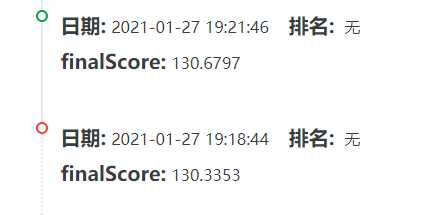